<a href="https://colab.research.google.com/github/rebanXtha/web/blob/main/Random_Forest_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rebanshrestharebe","key":"14b869dc1e66d40c190a17ee2c461a06"}'}

In [2]:
!pip install pandas numpy matplotlib seaborn


In [3]:
!pip install scikit-learn

In [4]:
!pip install xgboost

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
# Install Kaggle API (if not already installed)
!pip install kaggle

# Download the competition dataset
!kaggle competitions download -c store-sales-time-series-forecasting

!unzip store-sales-time-series-forecasting.zip



store-sales-time-series-forecasting.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [8]:
!ls


holidays_events.csv  sample_submission.csv		      train.csv
kaggle.json	     store-sales-time-series-forecasting.zip  transactions.csv
oil.csv		     stores.csv
sample_data	     test.csv


In [11]:
import pandas as pd

# Reload data
df = pd.read_csv("train.csv")

# Same dataset as SARIMAX
df1 = df[
    (df['store_nbr'] == 1) &
    (df['family'] == "GROCERY I")
].copy()

df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.sort_values('date').set_index('date')

# Final sales series (IDENTICAL to ARIMA)
sales = df1['sales'].asfreq('D').ffill()


In [12]:
print("Start date:", sales.index.min())
print("End date:", sales.index.max())
print("Total observations:", len(sales))


Start date: 2013-01-01 00:00:00
End date: 2017-08-15 00:00:00
Total observations: 1688


In [13]:
import pandas as pd

data = pd.DataFrame({'sales': sales})

# Lag features
for lag in [1, 7, 14, 28]:
    data[f'lag_{lag}'] = data['sales'].shift(lag)

# Rolling features
data['rolling_mean_7'] = data['sales'].rolling(7).mean()
data['rolling_mean_14'] = data['sales'].rolling(14).mean()
data['rolling_std_7'] = data['sales'].rolling(7).std()

# Calendar features
data['dayofweek'] = data.index.dayofweek
data['weekofyear'] = data.index.isocalendar().week.astype(int)
data['month'] = data.index.month

# Remove NaNs
data.dropna(inplace=True)


In [15]:
train_size = int(len(data) * 0.8)

train = data.iloc[:train_size]
test = data.iloc[train_size:]

X_train = train.drop('sales', axis=1)
y_train = train['sales']

X_test = test.drop('sales', axis=1)
y_test = test['sales']


In [16]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=15, min_samples_leaf=5, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [18]:
# Forecast sales for the test set
rf_forecast = rf_model.predict(X_test)

# Look at first 10 predictions
print(rf_forecast[:10])


[1157.16201559 2490.63534724 2594.95904658 2664.26961355 2365.18455975
 2555.71192528 2439.5380549  1102.85361936 2433.09884338 2452.51827329]


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, rf_forecast)
rmse = np.sqrt(mean_squared_error(y_test, rf_forecast))

print("Random Forest MAE:", mae)
print("Random Forest RMSE:", rmse)


Random Forest MAE: 353.84857129184445
Random Forest RMSE: 549.878626026401


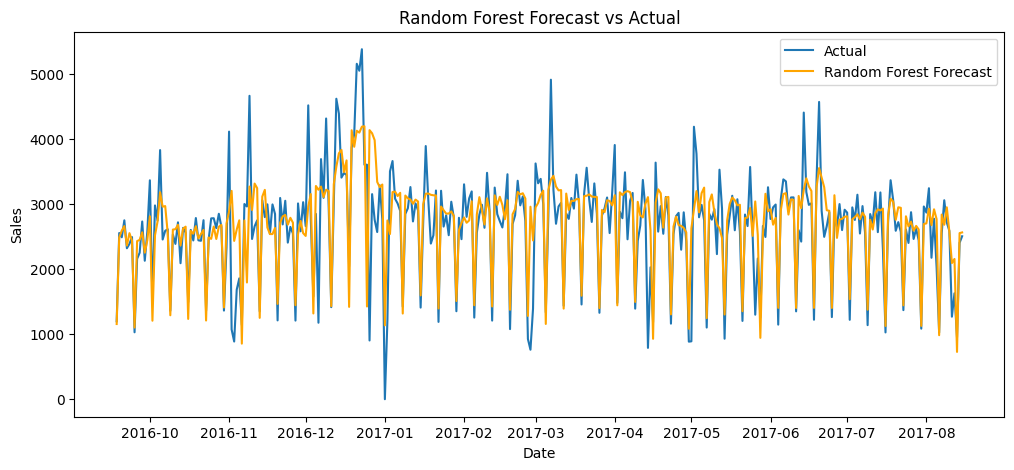

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, rf_forecast, label='Random Forest Forecast', color='orange')
plt.title("Random Forest Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()
